# Thermal Radiative Model Interface

This notebook will produce relevant figures from the accompanying publication. The first section uses a data file of measured secondary eclipses. The remaining sections are specific to a single planet. It imports existing MCMC results for likelihood optimization of the thermal model parameters.

***
##### Import shared packages.

In [48]:
import astropy.constants as C
import astropy.units as U
from astropy.analytic_functions import blackbody_lambda
import numpy as N
from scipy.stats import lognorm

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from colorcet import cm

import datetime

##### Import instrumental response data.

In [2]:
from data.bandpass.spitzer_IRAC import spitzer_IRAC as spitzer_IRAC
from data.bandpass.JHKs.TwoMASS import TwoMASS as TwoMASS
from data.bandpass.kepler import kepler as kepler
bandpasses = {**kepler.bandpass, **TwoMASS.bandpass, **spitzer_IRAC.bandpass}

***
## Secondary Eclipse Plots

##### Import data on measured eclipse depths in a variety of photometric bands, along with some system properties. We want to calculate the ratio of the measured depths to what the depth should be if the planet were radiating uniformly at its theoretical equilibrium temperature.

In [3]:
eclipse_file = N.genfromtxt('files/sec_eclipses.csv', delimiter=',', names=True, usecols=(range(1,15)), comments='#')
eclipse_names = N.genfromtxt('files/sec_eclipses.csv', delimiter=',', usecols=0, dtype=str, comments='#')[1:]

In [4]:
Teq = eclipse_file['TEFF'] * N.sqrt(0.5/eclipse_file['AR']) * U.K
Rs = eclipse_file['RSTAR'] * C.R_sun
Rp = eclipse_file['R'] * C.R_jup

In [5]:
flux_ratio = {}
for band in bandpasses:
    I_eq = N.array([N.dot(blackbody_lambda(in_x = bandpasses[band]['wavelength']*U.um, temperature = T), bandpasses[band]['weighted_spectrum']) for T in Teq])
    I_star = N.array([N.dot(blackbody_lambda(in_x = bandpasses[band]['wavelength']*U.um, temperature = T), bandpasses[band]['weighted_spectrum']) for T in eclipse_file['TEFF']*U.K])
    F_th = I_eq / I_star * (Rp/Rs)**2
    flux_ratio[band] = eclipse_file[band] / F_th

##### Plot a scatterplot of the ratio of observed eclipse depths to the thermal depths, as a function of equilibrium temperature.

In [6]:
plot_colors = ['#4575b4', '#74add1', '#abd9e9', '#e0f3f8', '#fee090', '#fdae61', '#f46d43', '#d73027']
plot_labels = [r'Kepler', r'$J$', r'$H$', r'$K_s$', r'3.6 $\mu$m', r'4.5 $\mu$m', r'5.8 $\mu$m', r'8.0 $\mu$m']

In [ ]:
fig, ax = plt.subplots()

for i, band in enumerate(bandpasses):
    ax.scatter(Teq, flux_ratio[band], c=plot_colors[i], label=plot_labels[i])
    
ax.axhline(1, c='k', linewidth=0.5, linestyle='dotted', alpha=0.5)

plt.xlabel(r'T$_\mathrm{eq}$ (K)', fontsize=18)
plt.ylabel(r'F$_\mathrm{obs}$/F$_\mathrm{eq}$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

plt.legend(loc='upper right', fontsize=9, ncol=2)

plt.savefig('eclipse_scatterplot.pdf', bbox_inches='tight')

##### Alternatively, we also may plot the eclipse flux ratios by rank order of temperature on the x-axis.

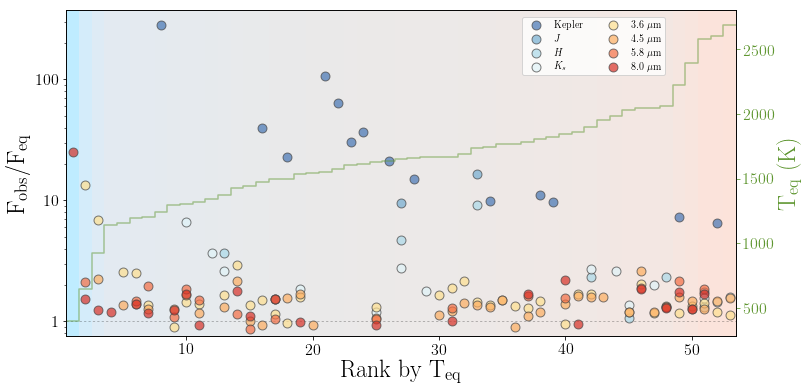

In [72]:
fig, ax = plt.subplots(figsize=(12, 6))

x_range = N.arange(1, len(Teq)+1)
ranked_Teq = N.argsort(Teq)
bgT_array = plt.get_cmap('cet_diverging_isoluminant_cjo_70_c25')((Teq[ranked_Teq] - N.min(Teq))/N.ptp(Teq))

for i, band in enumerate(bandpasses):
    ax.scatter(x_range, flux_ratio[band][ranked_Teq], c=plot_colors[i], edgecolors='#444444', s=80, alpha=0.7, label=plot_labels[i], zorder=10)

for x in x_range:
    ax.axvspan(x-0.5, x+0.5, facecolor=bgT_array[x-1], alpha=0.25, zorder=1)

ax.axhline(1, c='k', linewidth=0.5, linestyle='dotted', alpha=0.5)

ax.set_xlabel(r'Rank by T$_\mathrm{eq}$', fontsize=24)
ax.set_ylabel(r'F$_\mathrm{obs}$/F$_\mathrm{eq}$', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

ax.legend(loc=(0.68,0.8), fontsize=10, ncol=2)

axT = ax.twinx()
teq_color = '#609732'
axT.step(N.r_[x_range, N.shape(Teq)[0]+1]-0.5,
         N.r_[Teq[ranked_Teq].value, N.max(Teq).value],
         where='post',
         c=teq_color, alpha=0.5, zorder=2)
axT.set_ylabel(r'T$_\mathrm{eq}$ (K)', color=teq_color, fontsize=24)
axT.tick_params('y', colors=teq_color, labelsize=16)

ax.set_xlim([x_range[0]-0.5, x_range[-1]+0.5])

plt.savefig('eclipse_scatterplot_ranked.pdf', bbox_inches='tight')

##### Plot a histogram of the eclipse ratios, including a best-fit log-normal distribution.

In [ ]:
hist_arrays = {}
for band in bandpasses:
    #Plotting cut for the histogram above a ratio of 3.
    hist_arrays[band] = (flux_ratio[band])[flux_ratio[band] < 3.]
bins = N.histogram(N.hstack(hist_arrays.values()), bins=20)[1]
lognorm_fit = lognorm.fit(N.hstack(hist_arrays.values()), loc=N.log(1.4))

plt.hist(hist_arrays.values(),
         bins=bins, color=plot_colors,
         label=plot_labels,
         stacked=True, normed=True)

x = N.linspace(0.5,3,100)
plt.plot(x, lognorm.pdf(x, *lognorm_fit), c='#444444', linewidth=3, linestyle='dotted', alpha=0.5)

plt.text(0.95, 0.5, '$x_0=%.3f$\n$\mu=%.3f$\n$\sigma=%.3f$'%((lognorm_fit[1], N.log(lognorm_fit[2]), lognorm_fit[0])),
         transform=plt.gca().transAxes, fontsize=12, horizontalalignment='right', verticalalignment='center')
plt.legend(loc='upper right', fontsize=10, ncol=2)
plt.xlabel(r'F$_\mathrm{obs}$/F$_\mathrm{eq}$', fontsize=16)
plt.ylabel(r'Normalized Frequency', fontsize=16)

plt.savefig('eclipse_histogram.pdf', bbox_inches='tight')

##### We can construct the equivalent of a color-magnitude diagram for eclipse depths, where magnitudes are logarithms of eclipse ratios.

In [ ]:
def CMD(bands):
    x = N.log(flux_ratio[bands[1]][N.isfinite(flux_ratio[bands[0]]) & N.isfinite(flux_ratio[bands[1]])])
    y = (N.log(flux_ratio[bands[0]])-N.log(flux_ratio[bands[1]]))[N.isfinite(flux_ratio[bands[0]]) & N.isfinite(flux_ratio[bands[1]])]
    return {'mag': x, 'color': y}

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
CMDs = [CMD(['3p6', '4p5']), CMD(['4p5', '5p8']), CMD(['5p8', '8p0'])]
plot_colors = ['#E99425', '#E96225', '#D6224C']
plot_bands = [['3.6', '4.5'], ['4.5', '5.8'], ['5.8', '8.0']]

for i, (ax, cmag) in enumerate(zip(axes, CMDs)):
    ax.scatter(cmag['mag'], cmag['color'], c=plot_colors[i])
    ax.set_xlabel(r'$\log \left(F_\mathrm{{obs}}/F_\mathrm{{eq}}\right)$, {0}$\mu$m'.format(plot_bands[i][1]),fontsize=16)
    ax.set_ylabel(r'{0}$\mu$m - {1}$\mu$m'.format(*plot_bands[i]), fontsize=16)
    
plt.tight_layout()
plt.savefig('eclipse_CMD.pdf')

***
## Planet-specific Modules

##### The planet class contains all the methods used for the geometry of the planet-star system.

In [ ]:
from planet_class import Planet

##### Import the module for the thermal model.

In [ ]:
from thermal import blackbody as thermal_model

##### Import the system properties and data of the desired planet (contained in a Python dictionary in a separate file).

In [ ]:
#from data.planet.GJ436b import GJ436b as exoplanet
#from data.planet.HATP2b import HATP2b as exoplanet
#from data.planet.HATP7b import HATP7b as exoplanet
#from data.planet.HD80606b import HD80606b as exoplanet
#from data.planet.HD149026b import HD149026b as exoplanet
#from data.planet.HD189733b import HD189733b as exoplanet
from data.planet.HD209458b import HD209458b as exoplanet
#from data.planet.WASP12b import WASP12b as exoplanet
#from data.planet.WASP14b import WASP14b as exoplanet
#from data.planet.WASP18b import WASP18b as exoplanet
#from data.planet.WASP19b import WASP19b as exoplanet
#from data.planet.WASP33b import WASP33b as exoplanet
#from data.planet.WASP43b import WASP43b as exoplanet

##### Import the routine to convert surface temperatures to observed planet-star flux ratios in a given band.

In [ ]:
from data.bandpass.response import light_curve

##### Import the likelihood calculation routine.

In [ ]:
from stats.gaussian import log_likelihood
from stats.metropolis import MCMC

##### Import any visualization routines needed.

In [ ]:
from visualization import multi_animation
from visualization.style import colors
from visualization.lightcurve_plot import LightCurvePlot
from visualization.orbit_plot import OrbitPlot
from visualization.surface_plot import SurfacePlot

##### Create a planet instance with the user-supplied system properties.

In [ ]:
planet = Planet(exoplanet.system_properties)

***
## Best-Fit Model Light Curves from Existing MCMC Results

##### A wrapper function using the thermal model and light curve routines to start with a set of specified parameter values and return a light curve. This function will be passed to the statistical likelihood function.

In [ ]:
def generate_model(parameters, spectral_array):
    temperature_map = thermal_model.temperatures(planet=planet, parameters=parameters)
    model = light_curve(planet=planet,
                        temp_map=temperature_map,
                        spectral_array=spectral_array,
                        parameters=parameters,
                        use_tidal_distortion=False)
    return {'temp': temperature_map, 'model': model}

##### If there are saved MCMC outputs we want to use, import them here.

In [ ]:
mcmc_file = N.load('files/{0}_mcmc.npy'.format(planet.name.replace(" ", "")), encoding='latin1', fix_imports=True)[()]
mcmc_uncertainty_file = N.load('files/{0}_mcmc_uncertainties.npy'.format(planet.name.replace(" ", "")), encoding='latin1', fix_imports=True)[()]

##### For the MCMC routine we feed the parameters in as a list. The parameter order is:
1. Rotation period
2. Radiative timescale
3. Minimum temperature
4. Albedo

In [ ]:
mcmc_fit = {}
mcmc_uncertainty = {}
sigma_upper = {}
sigma_lower = {}

for band in exoplanet.data:
    mcmc_fit[band] = mcmc_file[band]['pos'][-1].squeeze() * [planet.pseudosynchronous_period(), U.hr, U.K, 1]
    print('Band: {0} um'.format(band.replace('p', '.')))
    print('Best-fit parameters:\n Rotation period = {0} ({4} PSR)\n Radiative timescale @ {5} = {1}\n Minimum temperature = {2}\n Albedo = {3}\n'.format(*mcmc_fit[band], mcmc_fit[band][0]/planet.pseudosynchronous_period(), planet.orbital_equilibrium_temperature().decompose()))
    
    mcmc_uncertainty[band] = mcmc_uncertainty_file[band]['pos'].squeeze()
    param_upper = [(mcmc_uncertainty[band].T[i])[mcmc_uncertainty[band].T[i] > fit] for i, fit in enumerate(mcmc_uncertainty[band][0])]
    param_lower = [(mcmc_uncertainty[band].T[i])[mcmc_uncertainty[band].T[i] < fit] for i, fit in enumerate(mcmc_uncertainty[band][0])]
    sigma_upper[band] = N.array([N.percentile(p, 68) - mcmc_uncertainty[band][0][i] for i, p in enumerate(param_upper)]) * [planet.pseudosynchronous_period(), U.hr, U.K, 1]
    sigma_lower[band] = N.array([N.percentile(p, 100-68) - mcmc_uncertainty[band][0][i] for i, p in enumerate(param_lower)]) * [planet.pseudosynchronous_period(), U.hr, U.K, 1]
    print('1-sigma bounds:\n Rotation period = +{0} ({4} PSR), {5} ({9} PSR)\n Radiative timescale @ {10} = +{1}, {6}\n Minimum temperature = +{2}, {7}\n Albedo = +{3}, {8}\n'.format(*sigma_upper[band], sigma_upper[band][0]/planet.pseudosynchronous_period(), *sigma_lower[band], sigma_lower[band][0]/planet.pseudosynchronous_period(), planet.orbital_equilibrium_temperature().decompose()))

##### Quick plots showing the trajectory of the MCMC walker(s) in each of the parameter dimensions, as well as the evolution of the likelihood.

In [ ]:
fig, axes = plt.subplots(5)
for i in range(4):
    for band in exoplanet.data:
        axes[i].plot((mcmc_file[band]['pos'].T)[i][0],color=colors.color_datlab[band])
        axes[4].plot(mcmc_file[band]['logl'],color=colors.color_datlab[band])

##### Pull the most favorable parameter values and make a grid of that single set to plot the flux curve(s). Then generate models for the most favorable parameters in each band.

In [ ]:
best_parameters = {}
best_rotation = {}
best_paramgrid = {}
best_model = {}

for band in exoplanet.data:
    best_parameters[band] = mcmc_fit[band]
    best_rotation[band] = best_parameters[band][0]
    best_paramgrid[band] = N.meshgrid(*best_parameters[band])
    
    planet.set_resolution(longitude_resolution = 72,
                          latitude_resolution = 36,
                          time_resolution = 200,
                          num_orbits = 5)
    
    best_model[band] = generate_model(best_paramgrid[band], spitzer_IRAC.bandpass[band])

##### For our transit depth analysis, we can optionally modify the data by translating the in-transit data up by the geometric transit depth. Then, use delta_data instead of exoplanet.data.

In [ ]:
delta_data = {}
for band in exoplanet.data:
    delta_data[band] = {'t':exoplanet.data[band]['t'],
                        'flux': None,
                        'occultation':exoplanet.data[band]['occultation']}

transit_dip = (planet.rp/planet.R)**2
print('Geometric transit depth: {0}'.format(transit_dip))

for band in delta_data:
    delta_data[band]['flux'] = N.where(exoplanet.data[band]['occultation']==b't',
                                       exoplanet.data[band]['flux'] + transit_dip,
                                       exoplanet.data[band]['flux'])

##### Initialize the light curve with our best-fit models in each model, then draw with arbitrary smoothing for the shaded region representing rough 1-sigma boundaries on the data.

In [ ]:
lightcurve_plot = LightCurvePlot(planet=planet,
                                 data=exoplanet.data,
                                 model=best_model,
                                 parameters=best_parameters)

In [ ]:
smoothing_parameters = {'GJ 436 b': {'8p0': 8.5e-7},
                        'HAT-P-2 b': {'3p6':9e-6, '4p5': 6e-6, '8p0': 8e-5},
                        'HAT-P-7 b': {'3p6':2e-5, '4p5': 1.1e-5},
                        'HD 80606 b': {'4p5':6.5e-7, '8p0': 5e-6},
                        'HD 149026 b': {'3p6':2e-6, '4p5': 1.6e-6},
                        'HD 189733 b': {'3p6':2e-6, '4p5': 1.5e-6, '8p0': 7.5e-6},
                        'HD 209458 b': {'4p5': 8e-6},
                        'WASP-12 b': {'3p6':2.25e-4, '4p5': 2.25e-4},
                        'WASP-14 b': {'3p6':2.5e-5, '4p5': 2.5e-5},
                        'WASP-18 b': {'3p6':1.5e-5, '4p5': 3e-5},
                        'WASP-19 b': {'3p6':1.25e-4, '4p5': 1.25e-4},
                        'WASP-33 b': {'3p6':7e-5, '4p5': 6e-5},
                        'WASP-43 b': {'3p6':9.25e-5, '4p5': 3e-5}}

In [ ]:
fig, ax = plt.subplots()
lightcurve_plot.draw(axis=ax,
                     s=smoothing_parameters[planet.name],
                     phase_overlap=0.25,
                     filetypes=['pdf'],
                     combo=False,
                     save=True)

***
## Orbit and Surface Plots

##### Draw a top-down orbit plot with equally time-spaced points.

In [ ]:
orbit_plot = OrbitPlot(planet, exoplanet.data, time_resolution = 32)

In [ ]:
fig, ax = plt.subplots()
orbit_plot.draw_static(axis=ax, filetypes=['pdf'], save=True)

##### Draw a projection of the planet surface with a quantity (e.g. temperature) plotted as a color map. Since we're going to animate this with the orbit plot, which has a time resolution different from the generated model time resolution, we need to select out every nth timestep, n given by the ratio.

In [ ]:
selected_band = '4p5'
surface_plot = SurfacePlot(planet,
                           rotation_period = best_rotation[selected_band]
                           map_array = (best_model[selected_band]['temp'].reshape(planet.time_resolution*planet.num_orbits,
                                                                          planet.latitude_resolution+1,
                                                                          planet.longitude_resolution+1)),
                           time_resolution = 32,
                           start_orbit = 3)

##### The multi_animation routine takes multiple visualizations and animates them together over a time series.

In [ ]:
orbit_plot.set_rotation_period(planet.P)
orbit_plot.set_num_orbits(3)
animation = multi_animation.draw(planet,
                                 plot_objects = [orbit_plot, surface_plot],
                                 num_orbits = 3)

***
## Miscellaneous Plots

##### One interesting plot is to look at a map of likelihoods in a 2D slice of parameter space. Here, we make a plot of rotation period versus radiative timescale, using an existing grid search with the other 2 parameters (minimum temperature, albedo) at values fixed to their best fits from MCMC. This shows us how degenerate the selection of the 2 timescale parameters is.

In [ ]:
degeneracy_file = N.load('files/{0}_grid.npy'.format(planet.name.replace(" ", "")), encoding='latin1', fix_imports=True)[()]

In [ ]:
pars = degeneracy_file['par'][:]
pars[0] = (pars[0]/planet.P).decompose()

degeneracy_grid = degeneracy_file['logl']['4p5'].squeeze()
best_index = N.unravel_index(N.argmin(degeneracy_grid), (len(pars[0]), len(pars[1])))
logl_min = N.nanmin(degeneracy_grid)

x, y = N.mgrid[pars[0][0]:pars[0][-1]:len(pars[0])*1j, pars[1][0]:pars[1][-1]:len(pars[1])*1j]
plt.pcolor(x, y, degeneracy_grid/logl_min, cmap='cet_fire_r', vmin=1, vmax=1.5)
cb = plt.colorbar()
cb.set_label('Scaled Log Likelihood', fontsize=16)
plt.xlabel(r'$P_{\mathrm{rot}}/P_{\mathrm{orb}}$', fontsize=16)
plt.ylabel(r'$\tau_{\mathrm{rad}}$ (hr)', fontsize=16)
plt.savefig('{0}_degeneracy.pdf'.format(planet.name.replace(" ", "")), bbox_inches='tight', transparent=True)